In [1]:
# Parameters
input_dir = "../../2.cellprofiler_ic_processing/illum_directory/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_E-11_F0004"
diameter = 70
clip_limit = 0.3

This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [2]:
import argparse

# set the gpu via OS environment variable
import os
import pathlib

import cellpose
import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
import torch
from cellpose import core, models
from csbdeep.utils import normalize
from PIL import Image
from stardist.plot import render_label

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)
# check if we have a GPU
use_gpu = torch.cuda.is_available()
print("GPU activated:", use_gpu)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.3 
platform:       	linux 
python version: 	3.10.17 
torch version:  	2.7.0+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


True
GPU activated: True


In [3]:
# set up memory profiler for GPU
device = torch.device("cuda:0")
free_before, total_before = torch.cuda.mem_get_info(device)
starting_level_GPU_RAM = (total_before - free_before) / 1024**2
print("Starting level of GPU RAM available (MB): ", starting_level_GPU_RAM)

Starting level of GPU RAM available (MB):  2121.5


## Set up images, paths and functions

In [4]:
image_extensions = {".tif", ".tiff"}
files = sorted(pathlib.Path(input_dir).glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]
print(len(files))

3


In [5]:
image_dict = {
    "nuclei_file_paths": [],
    "nuclei": [],
}

In [6]:
# split files by channel
for file in files:
    if "C01" in file.split("/")[-1]:
        image_dict["nuclei_file_paths"].append(file)
        image_dict["nuclei"].append(tifffile.imread(file).astype(np.float32))
nuclei_image_list = [np.array(nuclei) for nuclei in image_dict["nuclei"]]

nuclei = np.array(nuclei_image_list).astype(np.int16)

nuclei = skimage.exposure.equalize_adapthist(nuclei, clip_limit=clip_limit)

nuclei_image_list = [np.array(nuclei_image) for nuclei_image in nuclei]
print(len(nuclei_image_list))

1


## Cellpose

Weird errors occur when running this converted notebook in the command line.
This cell helps the python interpreter figure out where it is...somehow.

In [7]:
use_GPU = core.use_gpu()
print("GPU activated: ", use_GPU)
model = models.CellposeModel(gpu=use_GPU)


masks_all_dict = {"masks": [], "imgs": []}


# get masks for all the images
# save to a dict for later use
for img in range(nuclei.shape[0]):
    nuclei[img, :, :] = normalize(nuclei[img, :, :])

results = [
    (
        img,
        nuclei[img, :, :].shape,
        model.eval(
            nuclei[img, :, :],
        ),
    )
    for img in range(nuclei.shape[0])
]

# Print the results
for img, shape, (masks, flows, styles) in results:
    masks_all_dict["masks"].append(masks)
    masks_all_dict["imgs"].append(img)


masks_all = masks_all_dict["masks"]
imgs = masks_all_dict["imgs"]
masks_all = np.array(masks_all)
imgs = np.array(imgs)
print(masks_all.shape)
print(imgs.shape)

for frame_index, frame in enumerate(image_dict["nuclei_file_paths"]):
    tifffile.imwrite(
        pathlib.Path(
            f"{input_dir}/{str(frame).split('/')[-1].split('_C01')[0]}_nuclei_mask.tiff"
        ),
        masks_all[frame_index, :, :],
    )

GPU activated:  True
device: cuda:0
gpu: True
(1, 1900, 1900)
(1,)


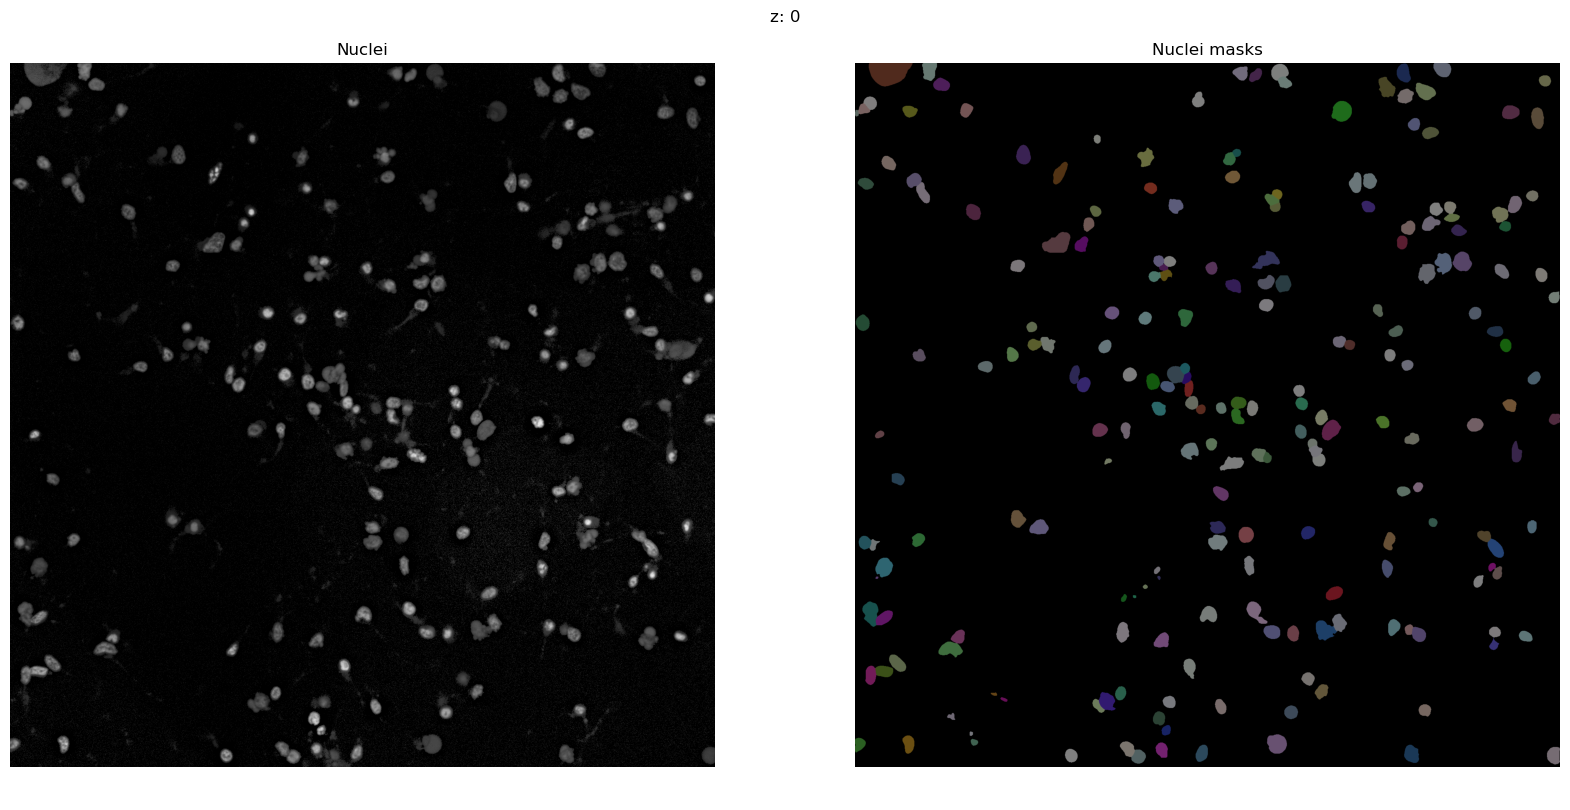

In [8]:
if in_notebook:
    for z in range(len(masks_all)):
        plt.figure(figsize=(20, 10))
        plt.title(f"z: {z}")
        plt.axis("off")
        plt.subplot(1, 2, 1)
        plt.imshow(nuclei[z], cmap="gray")
        plt.title("Nuclei")
        plt.axis("off")

        plt.subplot(122)
        plt.imshow(render_label(masks_all[z]))
        plt.title("Nuclei masks")
        plt.axis("off")
        plt.show()

In [9]:
# set up memory profiler for GPU
device = torch.device("cuda:0")
free_after, total_after = torch.cuda.mem_get_info(device)
amount_used = ((total_after - free_after)) / 1024**2
print(f"Used: {amount_used} MB or {amount_used / 1024} GB of GPU RAM")

Used: 6857.5 MB or 6.69677734375 GB of GPU RAM
